
### Price Trajectories
Modeled by [Wiener Process](https://en.wikipedia.org/wiki/Wiener_process)

### Data:
#### The Graph (Compound-v2)
Used for current total borrowed

#### Coingecko (Historical Prices)
Use file: `data/coingeckoe_prices.csv`

Created by download script `download_historical_prices.py`. The script has a runtime of ~1h, because it sends about 600 requests to coingecko. The free API allows 10-50 requests / minute, so I use a sleep of 6 seconds to never send more than 10 requests / minute. 

Time window: `2022-11-21` to `2022-11-20`

Should be updated if gets too old compared to the timestamp of data from The Graph. 


## Assumptions

- total supply = total borrows + free
- when asset is twice in graph list (wbtc, dai) only take the one with bigger borrows, drop the other
- exchange rate and collateral factor don't change

## documentation
- If an asset has a 0% collateral factor, it can’t be used as collateral (or seized in liquidation), though it can still be borrowed.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import json

from src.coingecko import CoingeckoAPI
from src.the_graph import TheGraphAPI

PRICES_FILE = Path.cwd().joinpath("data", "coingecko_prices.csv")
PARAMS_FILE = Path.cwd().joinpath("configs", "parameters.json")


In [2]:
# get current Compound Borrows from The Graph

tg_api = TheGraphAPI()
borrows = tg_api.get_compound_borrows()

col_dtypes = {
    "underlyingSymbol":str,
    "underlyingName":str, 
    "totalBorrows":float,	
    "totalSupply":float,
    "collateralFactor":float,	
    "exchangeRate":float,
    "underlyingPriceUSD":float,	
    "blockTimestamp":int,
    }
borrows_df = pd.DataFrame(borrows)
borrows_df = borrows_df.apply(lambda c: c.astype(col_dtypes[c.name]))
borrows_df

,underlyingSymbol,underlyingName,collateralFactor,exchangeRate,totalBorrows,totalSupply,underlyingPriceUSD,blockTimestamp
0,USDP,Pax Dollar,0.000,0.020194,1.973558e+04,1.473143e+06,1.000000,1669103195
1,TUSD,TrueUSD,0.000,0.020552,5.487149e+06,3.924372e+08,1.000000,1669103147
2,REP,Reputation,0.000,0.020041,5.590882e+01,5.470486e+04,6.961100,1667094731
3,UNI,Uniswap,0.750,0.020299,4.302135e+05,2.186839e+08,5.105811,1669122563
4,USDC,USD//C,0.855,0.022679,2.569219e+08,2.990706e+10,1.000000,1669125299
5,SUSHI,SushiToken,0.700,0.020470,6.628300e+05,1.403753e+08,1.104256,1669121123
6,ETH,Ether,0.825,0.020076,1.377330e+04,1.834845e+07,1127.190000,1669125515
7,DAI,Dai Stablecoin,0.835,0.022105,1.816035e+08,1.788565e+10,1.001113,1669124063
8,BAT,Basic Attention Token,0.650,0.020676,4.445937e+05,7.201187e+09,0.212466,1669114283
9,COMP,Compound,0.650,0.020414,1.034903e+04,3.062483e+07,36.450000,1669122479


Have two entries for `DAI` and `wBTC` each... only keep the bigger one for now
```
{
  "underlyingSymbol": "DAI",
  "underlyingName": "Dai Stablecoin",
  "borrowRate": "0.0233026004452608",
  "totalBorrows": "211524161.923877439677332104",
  "collateralFactor": "0.835",
  "underlyingPriceUSD": "1.000773",
  "blockTimestamp": 1669045535,
  "accrualBlockNumber": 16019369
},
{
  "underlyingSymbol": "DAI",
  "underlyingName": "Dai Stablecoin v1.0 (DAI)",
  "borrowRate": "0.0501467542606656",
  "totalBorrows": "240.64852988575940222",
  "collateralFactor": "0",
  "underlyingPriceUSD": "6.210826",
  "blockTimestamp": 1668979619,
  "accrualBlockNumber": 16013904
},
....
{
  "underlyingSymbol": "WBTC",
  "underlyingName": "Wrapped BTC",
  "borrowRate": "0.0206864728473312",
  "totalBorrows": "0.39387562",
  "collateralFactor": "0.7",
  "underlyingPriceUSD": "15929.996902",
  "blockTimestamp": 1669001867,
  "accrualBlockNumber": 16015751
},
{
  "underlyingSymbol": "WBTC",
  "underlyingName": "Wrapped BTC",
  "borrowRate": "0.0221761103560704",
  "totalBorrows": "152.21575285",
  "collateralFactor": "0.7",
  "underlyingPriceUSD": "16182.771321",
  "blockTimestamp": 1669043411,
  "accrualBlockNumber": 16019192
},
```

In [3]:
borrows_df = borrows_df.sort_values(by=["underlyingSymbol", "totalBorrows"], ascending=False).reset_index(drop=True)
borrows_df = borrows_df.drop_duplicates(subset=["underlyingSymbol"]).sort_values(by=["underlyingSymbol"])
borrows_df

,underlyingSymbol,underlyingName,collateralFactor,exchangeRate,totalBorrows,totalSupply,underlyingPriceUSD,blockTimestamp
18,AAVE,Aave Token,0.730,0.020303,7.457000e+03,7.604850e+05,53.774305,1669125479
17,BAT,Basic Attention Token,0.650,0.020676,4.445937e+05,7.201187e+09,0.212466,1669114283
16,COMP,Compound,0.650,0.020414,1.034903e+04,3.062483e+07,36.450000,1669122479
14,DAI,Dai Stablecoin,0.835,0.022105,1.816035e+08,1.788565e+10,1.001113,1669124063
13,ETH,Ether,0.825,0.020076,1.377330e+04,1.834845e+07,1127.190000,1669125515
12,FEI,Fei USD,0.000,0.020136,2.496479e+03,8.882565e+04,0.997575,1667774747
11,LINK,ChainLink Token,0.790,0.020171,2.484818e+04,3.448737e+07,5.926123,1669115363
10,REP,Reputation,0.000,0.020041,5.590882e+01,5.470486e+04,6.961100,1667094731
9,SUSHI,SushiToken,0.700,0.020470,6.628300e+05,1.403753e+08,1.104256,1669121123
8,TUSD,TrueUSD,0.000,0.020552,5.487149e+06,3.924372e+08,1.000000,1669103147


### Monte Carlo Simulation
- Calculate Volatilties
- Simulate Price Paths

In [4]:
from src.measures import calc_volatility, monte_carlo_simulation

with open(PARAMS_FILE) as f:
    params = json.load(f)
    
# load historical prices from coingecko (used scrip `download_historica_prices.ipynb` to prepare data)
prices = pd.read_csv(PRICES_FILE)
symbols = sorted(prices["symbol"].unique())

# calculate volatilities
vols = {}
for symbol in symbols:
    p = prices[prices["symbol"] == symbol]["price"].values
    vols[symbol] = calc_volatility(p)

print(vols)

{'aave': 0.07464626572283103, 'bat': 0.06004059637910412, 'comp': 0.06638834095565146, 'dai': 0.002007655992637203, 'eth': 0.06422278659986509, 'fei': 0.02851061647386272, 'link': 0.07018952104224735, 'rep': 0.07171938656321616, 'sushi': 0.09514300836715131, 'tusd': 0.00282056858179138, 'uni': 0.0697395479254225, 'usdc': 0.0021574718617547875, 'usdp': 0.0043466418878502005, 'usdt': 0.0019460020558690057, 'wbtc': 0.04429704461003883, 'yfi': 0.06864343781384731, 'zrx': 0.0728031524419769}


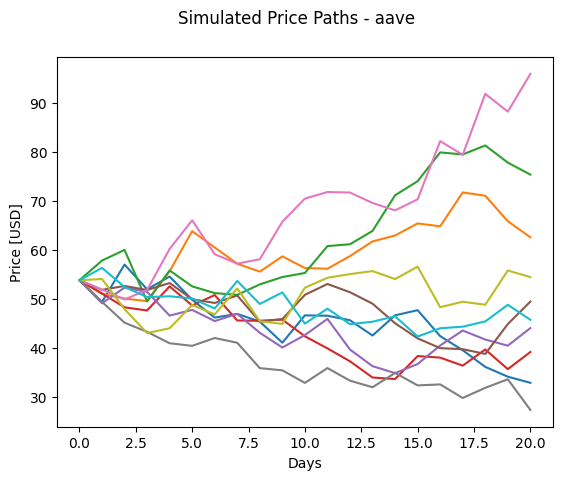

In [5]:
# plot example of Monte Carlo Paths (aave)
from src.measures import simulate_path
from src.plots import plot_mc_paths
from matplotlib import pyplot as plt

symbol = "aave"
price = borrows_df[borrows_df["underlyingSymbol"] == symbol.upper()]["underlyingPriceUSD"].iloc[0]
paths = [simulate_path(price, vols[symbol], horizon=20) for _ in range(10)]

fig = plot_mc_paths(symbol, paths)
plt.show()

In [6]:
# Simulate Monte Carlo Paths for all Symbols
mc_paths = {}
for symbol in symbols:
    price = borrows_df[borrows_df["underlyingSymbol"] == symbol.upper()]["underlyingPriceUSD"].iloc[0]
    mc_paths[symbol] = monte_carlo_simulation(price, vols[symbol], params["mc_horizon"], params["mc_paths"])



# Calculate Value of Borrows and Supplies

- value of cTokens in USD: `amount_cToken * exchange_rate * price_usd`
- value of Supply: `supply_value * collateralFactor`
- value of Borrow: `borrow_value`

## VaR
For the Value at Risk, I handled the protocol like a portfolio. The current value $V(t_{0})$ of the portfolio is:

$V(t_{0}) = \sum_{assets} (supply\_value(t_{0}) - borrow\_value(t_{0}))$

Then the N paths with horizon $h$ are simulated for each asset and we get N potential values of the portfolio in the future. 
(same calculatian as before, only with simulated `price_usd`)

$V_{k}(t_{h}) = \sum_{assets} (supply\_value(t_{h}) - borrow\_value(t_{h}))$

From this we can calculate N returns ($R_k = V_{k}(t_{h})/ V(t_{0}), k=1,...,N$). And look at the distribution of the returns $R_k$.

The VaR is then defined as the .....



In [8]:
from src.measures import calc_borrow_value_usd, calc_supply_value_usd

borrows_df["borrowValue"] = calc_borrow_value_usd(
    n_ctoken=borrows_df["totalBorrows"].values, 
    exchange_rate=borrows_df["exchangeRate"].values, 
    prices=borrows_df["underlyingPriceUSD"].values
)

borrows_df["supplyValue"] = calc_supply_value_usd(
    n_ctoken=borrows_df["totalSupply"].values, 
    exchange_rate=borrows_df["exchangeRate"].values, 
    collateral_factor=borrows_df["collateralFactor"].values,
    prices=borrows_df["underlyingPriceUSD"].values
)

print(f"Overall Supply Value USD: {borrows_df['supplyValue'].sum()} (collateralized)")
print(f"Overall Borrow Value USD: {borrows_df['borrowValue'].sum()}")
borrows_df[["underlyingSymbol", "totalSupply", "totalBorrows", "supplyValue", "borrowValue", 
            "underlyingPriceUSD", "collateralFactor", "exchangeRate"]]

Overall Supply Value USD: 1490812836.776495 (collateralized)
Overall Borrow Value USD: 14035049.914011337


,underlyingSymbol,totalSupply,totalBorrows,supplyValue,borrowValue,underlyingPriceUSD,collateralFactor,exchangeRate
18,AAVE,7.604850e+05,7.457000e+03,6.061112e+05,8.141471e+03,53.774305,0.730,0.020303
17,BAT,7.201187e+09,4.445937e+05,2.056227e+07,1.953066e+03,0.212466,0.650,0.020676
16,COMP,3.062483e+07,1.034903e+04,1.481214e+07,7.700701e+03,36.450000,0.650,0.020414
14,DAI,1.788565e+10,1.816035e+08,3.304986e+08,4.018860e+06,1.001113,0.835,0.022105
13,ETH,1.834845e+07,1.377330e+04,3.425514e+08,3.116810e+05,1127.190000,0.825,0.020076
12,FEI,8.882565e+04,2.496479e+03,0.000000e+00,5.014699e+01,0.997575,0.000,0.020136
11,LINK,3.448737e+07,2.484818e+04,3.256712e+06,2.970206e+03,5.926123,0.790,0.020171
10,REP,5.470486e+04,5.590882e+01,0.000000e+00,7.799562e+00,6.961100,0.000,0.020041
9,SUSHI,1.403753e+08,6.628300e+05,2.221167e+06,1.498286e+04,1.104256,0.700,0.020470
8,TUSD,3.924372e+08,5.487149e+06,0.000000e+00,1.127725e+05,1.000000,0.000,0.020552


### How would the Monte Carlo simulated prices affect the supply and borrow vlaues?

In [18]:

from src.plots import plot_returns_histogram

mc_prices = pd.DataFrame(mc_paths).T

mc_borrow_values = calc_borrow_value_usd(
    n_ctoken=borrows_df["totalBorrows"].values, 
    exchange_rate=borrows_df["exchangeRate"].values, 
    prices=mc_prices.values
)
mc_supply_values = calc_supply_value_usd(
    n_ctoken=borrows_df["totalSupply"].values, 
    exchange_rate=borrows_df["exchangeRate"].values, 
    collateral_factor=borrows_df["collateralFactor"].values,
    prices = mc_prices.values
)

# calculate simulated returns of portfolio
original_value = borrows_df["supplyValue"].sum() - borrows_df["borrowValue"].sum()
simulated_values = (mc_supply_values.sum(axis=0) - mc_borrow_values.sum(axis=0))
returns = simulated_values / original_value


fig = plot_returns_histogram(returns, params['mc_paths'])


ImportError: cannot import name 'plot_returns_histogram' from 'src.plots' (/Users/franwe/repos/Compound/src/plots.py)

In [ ]:
# return at the percentile (params["var_percentile"]):

var_critical_return = np.percentile(returns, q=params["var_percentile"])
print(f"There is a {int(params['var_percentile']*100)}% chance that the portfolio will have a return of less than {var_critical_return:.4f} within {params['mc_horizon']} days.")
print("Return of 1 means same value as at beginning, >1 gain, <1 loss.")

There is a 10% chance that the portfolio will have a return of less than 0.7490 within 100 days.
Return of 1 means same value as at beginning, >1 gain, <1 loss.
